<a href="https://colab.research.google.com/github/Atit-Bashyal/Merkel_1/blob/main/Bayesian_GAM_Timeseries_long_term.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install torch
!pip3 install pyro-ppl 
!pip3 install arviz
!pip install pymc3==3.8


     |████████████████████████████████| 614kB 5.6MB/s 
     |████████████████████████████████| 1.5MB 5.4MB/s 
     |████████████████████████████████| 4.7MB 18.0MB/s 
     |████████████████████████████████| 737kB 45.2MB/s 
     |████████████████████████████████| 296kB 50.6MB/s 
  Found existing installation: xarray 0.15.1
    Uninstalling xarray-0.15.1:
      Successfully uninstalled xarray-0.15.1
     |████████████████████████████████| 911kB 4.3MB/s 
  Found existing installation: pymc3 3.7
    Uninstalling pymc3-3.7:
      Successfully uninstalled pymc3-3.7


In [ ]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import theano
import theano.tensor as tt
from fbprophet import Prophet
import seaborn as sns





In [ ]:
def seris_plot(dataset,column_str = 'power',date_col = 'datetime'):
  plt.figure(figsize=(8,8))
  plt.plot(dataset[date_col], dataset[column_str], marker='.', label="Original Dataset")
  plt.tight_layout()

  sns.despine(top=True)
  plt.subplots_adjust(left=0.07)
  plt.ylabel('{}'.format(column_str), size=15)
  plt.xlabel('Time step', size=15)
  plt.legend(fontsize=15)
  plt.show()

def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)

def fourier_series(t, p=365.25, n=10):
    # 2 pi n / p
    x = 2 * np.pi * np.arange(1, n + 1) / p
    # 2 pi n / p * t
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

 
 

In [ ]:
merkel_1 = pd.read_csv('/content/drive/MyDrive/Wind_turbines/Meckel_1.csv',parse_dates=[0],index_col=0)
merkel_4 = pd.read_csv('/content/drive/MyDrive/Wind_turbines/Meckel_4.csv',parse_dates=[0],index_col=0)
rens_3 = pd.read_csv('/content/drive/MyDrive/Wind_turbines/Reinsfeld_3.csv',parse_dates=[0],index_col=0)

In [ ]:
merkel_1_p = pd.DataFrame(merkel_1[['power','wind_speed']].resample('1D').mean())
merkel_1_p = merkel_1_p.reset_index()

In [ ]:
merkel_1_p['power_scaled'] = merkel_1_p['power'] / merkel_1_p['power'].max()
merkel_1_p['wind_scaled'] = merkel_1_p['wind_speed'] / merkel_1_p['wind_speed'].max()
merkel_1_p['t'] = (merkel_1_p['datetime'] - merkel_1_p['datetime'].min()) / (merkel_1_p['datetime'].max() - merkel_1_p['datetime'].min())




In [ ]:
merkel_1_p

,datetime,power,wind_speed,power_scaled,wind_scaled,t
0,2019-02-13 12:30:00,-0.003,0.8,-0.000002,0.028571,0.000000
1,2019-02-13 12:45:00,-0.003,0.8,-0.000002,0.028571,0.000029
2,2019-02-13 13:00:00,-0.003,0.9,-0.000002,0.032143,0.000057
3,2019-02-13 13:15:00,-0.003,0.8,-0.000002,0.028571,0.000086
4,2019-02-13 13:30:00,-0.003,0.8,-0.000002,0.028571,0.000115
...,...,...,...,...,...,...
35035,2020-02-12 05:15:00,941.369,10.0,0.547152,0.357143,0.999885
35036,2020-02-12 05:30:00,1133.525,11.6,0.658838,0.414286,0.999914
35037,2020-02-12 05:45:00,799.203,8.2,0.464521,0.292857,0.999943
35038,2020-02-12 06:00:00,1418.900,11.5,0.824707,0.410714,0.999971


In [ ]:
def trend_model(m, t, n_changepoints=10, changepoints_prior_scale=0.3, 
                growth_prior_scale=5, changepoint_range=0.8):

    s = np.linspace(0, changepoint_range * np.max(t), n_changepoints + 1)[1:]
    
    # * 1 casts the boolean to integers
    A = (t[:, None] > s) * 1

    with m:
        # initial growth
        k = pm.Normal('k', 0 , growth_prior_scale)
        
        if changepoints_prior_scale is None:
            changepoints_prior_scale = pm.Exponential('tau', 1.5)
        
        # rate of change
        delta = pm.Laplace('delta', 0, changepoints_prior_scale, shape=n_changepoints)
        # offset
        m = pm.Normal('m', 0, 5)
        gamma = -s * delta
        
        g = (k + det_dot(A, delta)) * t + (m + det_dot(A, gamma))
    return g, A, s



In [ ]:
# Generate a PyMC3 Model context
m = pm.Model()

with m:
    y, A, s = trend_model(m, merkel_1_p['t'])
    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
    pm.Normal('obs', 
                 mu=y,
                 sd=sigma,
                 observed=merkel_1_p['power_scaled'])

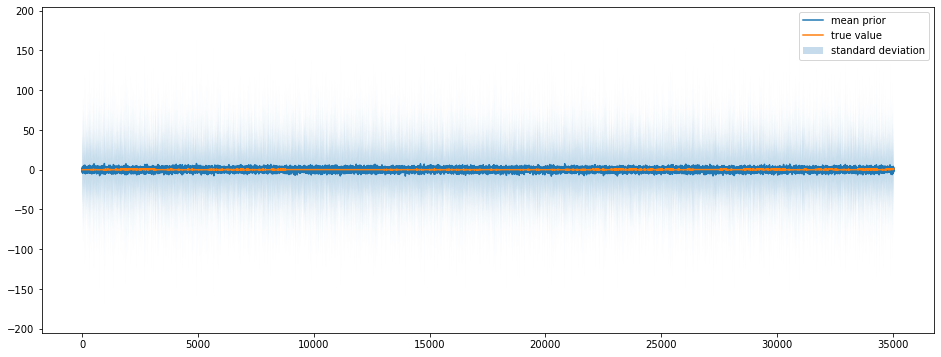

In [ ]:
def utility_check(m, df):
 
    # Sample from the prior and check if the model is well defined.
    y = pm.sample_prior_predictive(model=m, vars=['obs'])['obs']
    plt.figure(figsize=(16, 6))
    plt.plot(y.mean(0), label='mean prior')
    plt.fill_between(np.arange(y.shape[1]), -y.std(0), y.std(0), alpha=0.25, label='standard deviation')
    plt.plot(merkel_1_p['power_scaled'], label='true value')
    plt.legend()

# run
utility_check(m, merkel_1_p)

logp = 11,210, ||grad|| = 4.8469: 100%|██████████| 527/527 [00:05<00:00, 97.12it/s]  


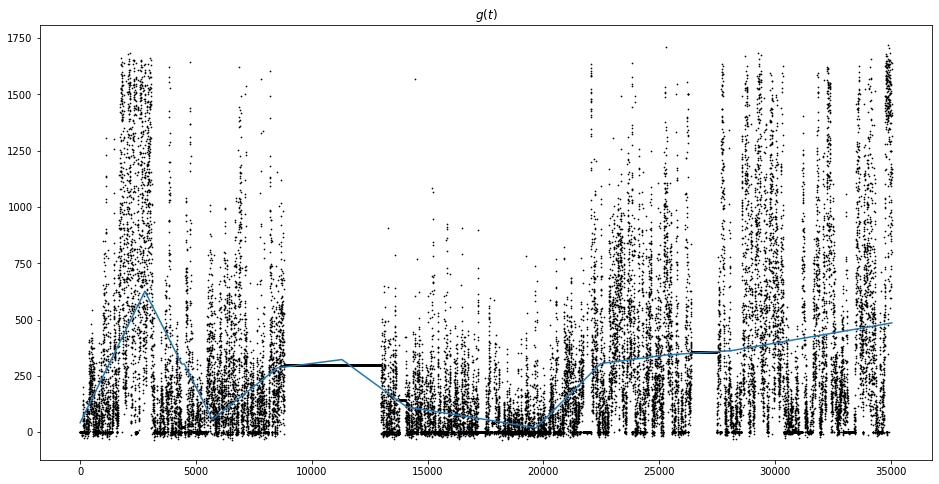

In [ ]:
# Find a point estimate of the models parameters
with m:
    aprox = pm.find_MAP()

# Determine g, based on the parameters
def det_trend(k, m, delta, t, s, A):
    return (k + np.dot(A, delta)) * t + (m + np.dot(A, (-s * delta)))

# run function and rescale to original scale
g = det_trend(aprox['k'], aprox['m'], aprox['delta'], merkel_1_p['t'], s, A) * merkel_1_p['power'].max()

plt.figure(figsize=(16, 8))
plt.title('$g(t)$')
plt.plot(g)
plt.scatter(np.arange(merkel_1_p.shape[0]), merkel_1_p.power, s=0.5, color='black')

In [ ]:
def seasonality_weekly(m, df, seasonality_prior_scale=10):
  n = 3
  # rescale the period, as t is also scaled
  p = 7 / (merkel_1_p['datetime'].max() - merkel_1_p['datetime'].min()).days 
  x = fourier_series(merkel_1_p['t'], p, n)
  with m:
      beta = pm.Normal('beta_weekly', mu=0, sd=seasonality_prior_scale, shape=2 * n)
  return x, beta

def seasonality_monthly(m, df, seasonality_prior_scale=10):
  n = 10
  # rescale the period, as t is also scaled
  p = 31 / (merkel_1_p['datetime'].max() - merkel_1_p['datetime'].min()).days 
  x = fourier_series(merkel_1_p['t'], p, n)
  with m:
      beta = pm.Normal('beta_monthly', mu=0, sd=seasonality_prior_scale, shape=2 * n)
  return x, beta

def seasonality_yearly(m, df, seasonality_prior_scale=10):
  n = 20
  # rescale the period, as t is also scaled
  p = 365/ (merkel_1_p['datetime'].max() - merkel_1_p['datetime'].min()).days 
  x = fourier_series(merkel_1_p['t'], p, n)
  with m:
      beta = pm.Normal('beta_yearly', mu=0, sd=seasonality_prior_scale, shape=2 * n)
  return x, beta

In [ ]:
m = pm.Model()



with m:
    # changepoints_prior_scale is None, so the exponential distribution
    # will be used as prior on \tau.
    y, A, s = trend_model(m, merkel_1_p['t'], changepoints_prior_scale=None)
    x_weekly, beta_weekly = seasonality_weekly(m, merkel_1_p)
    x_monthly, beta_monthly = seasonality_monthly(m, merkel_1_p)
  

 

    

    
    
    y +=  det_dot(x_monthly, beta_monthly) + det_dot(x_weekly, beta_weekly) 


    
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
  

    obs = pm.Normal('obs', 
                 mu=y, 
                 sd=sigma,
                 observed=merkel_1_p['power_scaled'])
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_monthly, beta_weekly, m, delta, tau, k]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [5:29:28<00:00,  9.88s/draws]
The acceptance probability does not match the target. It is 0.908063192036818, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe9dbf99780>,
      dtype=object)

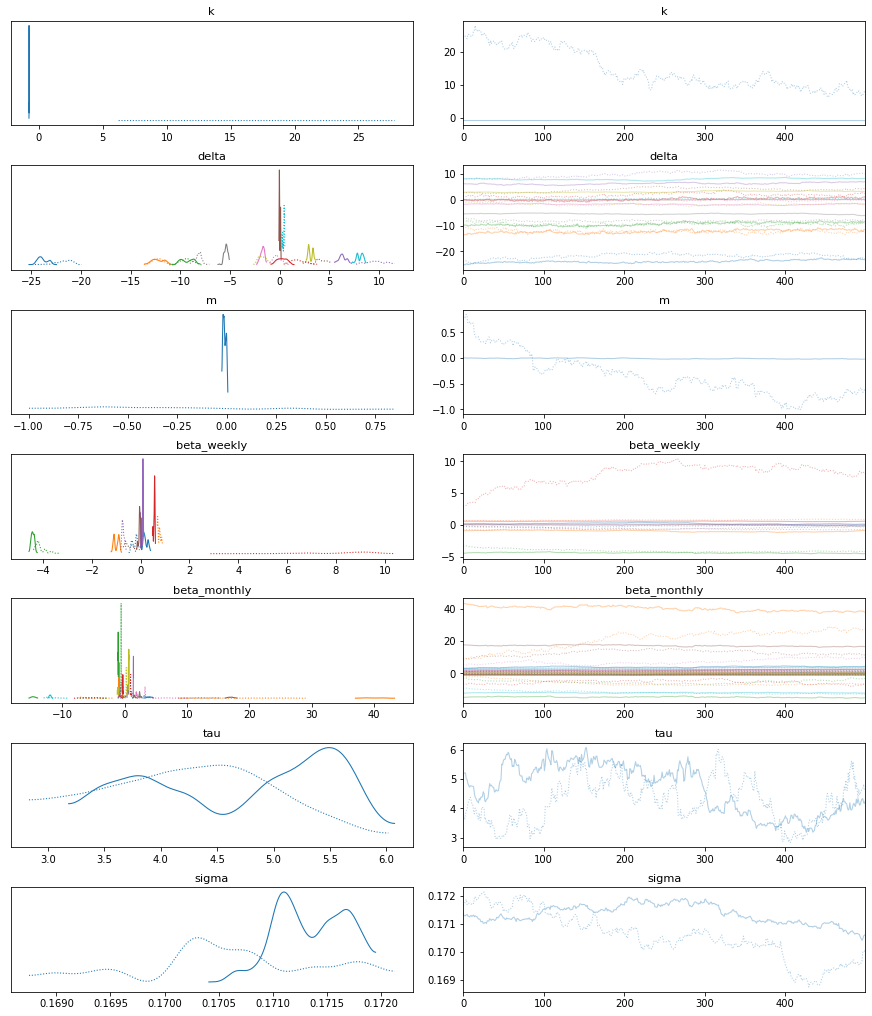

In [ ]:

with m:
    trace = pm.sample(500,cores=2)
pm.traceplot(trace)

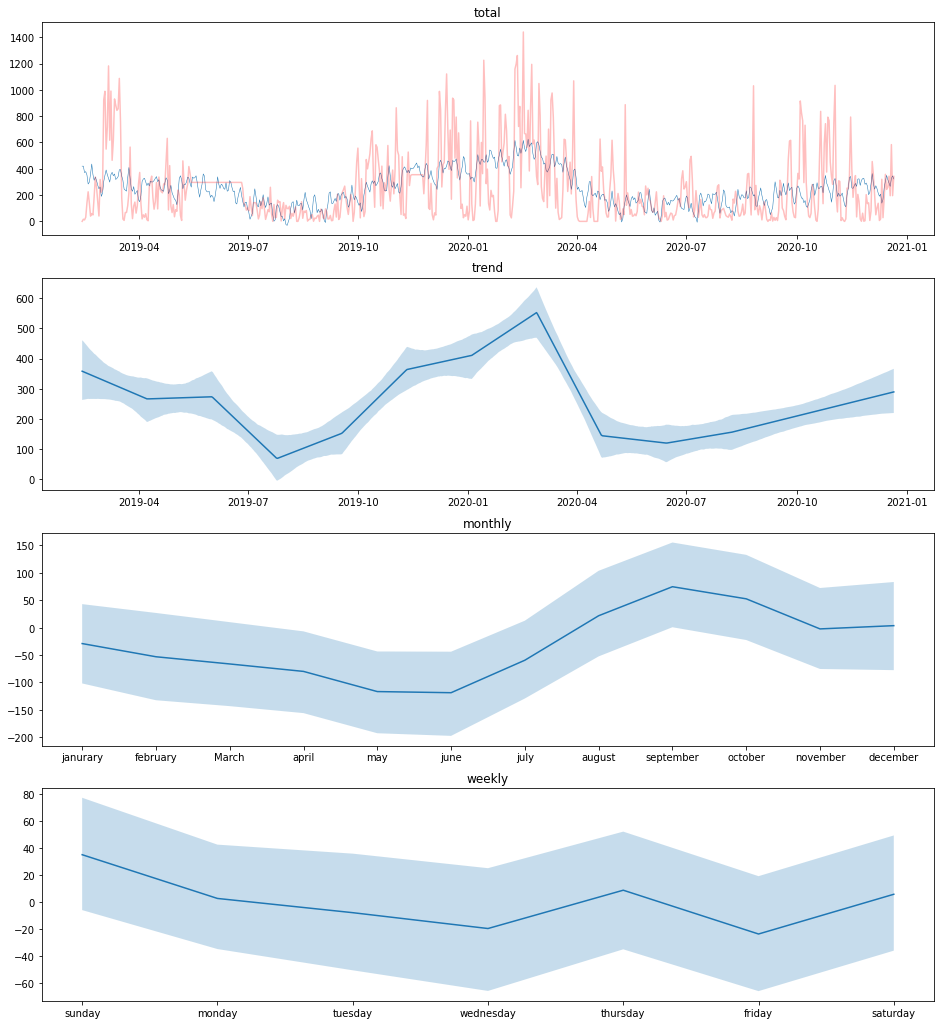

In [ ]:
def det_posterior(beta, x):
    return np.dot(x, beta.T)

p = 0.025 # Value for credeble interval 

wind_data = theano.shared(merkel_1_p['wind_speed'].values)

# vector distributions

beta_monthly = trace['beta_monthly']
beta_weekly = trace['beta_weekly']
delta = trace['delta']

# scalar distributions
k = trace['k']
m = trace['m']


# determine the posterior by evaulating all the values in the trace.

trend_posterior = ((k + np.dot(A, delta.T)) * merkel_1_p['t'][:, None] + m + np.dot(A, (-s * delta).T)) * merkel_1_p['power'].max()
weekly_posterior = det_posterior(beta_weekly, x_weekly) * merkel_1_p['power'].max()
monthly_posterior = det_posterior(beta_monthly, x_monthly) * merkel_1_p['power'].max()



date = merkel_1_p['datetime'].dt.to_pydatetime()
sunday = np.argmax(merkel_1_p['datetime'].dt.dayofweek)
weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
janurary = np.argmax(merkel_1_p['datetime'].dt.month)
Months = ['janurary', 'february', 'March', 'april', 'may', 'june', 'july','august','september','october','november','december']
idx_year = np.argmax(merkel_1_p['datetime'].dt.dayofyear)




plt.figure(figsize=(16, 3*6))
b = 411
plt.subplot(b)
plt.title('total')
plt.plot(date,
         (trend_posterior  + weekly_posterior + monthly_posterior).mean(1), lw=0.5)
plt.plot(date, merkel_1_p['power'], color='red',alpha=0.25)

plt.subplot(b + 1)
plt.title('trend')
plt.plot(date, trend_posterior.mean(1))
quant = np.quantile(trend_posterior, [p, 1 - p], axis=1)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)


plt.subplot(b + 2)
plt.title('monthly')
plt.plot(Months, monthly_posterior.mean(1)[janurary: janurary + 12])
quant = np.quantile(monthly_posterior, [p, 1 - p], axis=1)
plt.fill_between(Months, quant[0, janurary: janurary + 12],
                 quant[1, janurary: janurary + 12], alpha=0.25)


plt.subplot(b + 3)
plt.title('weekly')
plt.plot(weekdays, weekly_posterior.mean(1)[sunday: sunday + 7])
quant = np.quantile(weekly_posterior, [p, 1 - p], axis=1)
plt.fill_between(weekdays, quant[0, sunday: sunday + 7],
                 quant[1, sunday: sunday + 7], alpha=0.25)



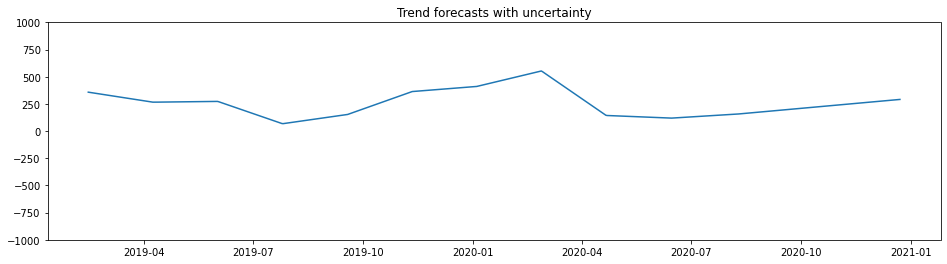

In [ ]:
n_changepoints = 10
n_samples = 1000
days = 2
history_points = merkel_1_p.shape[0]
probability_changepoint = n_changepoints / history_points

future = pd.DataFrame({'datetime': pd.date_range(merkel_1_p['datetime'].min(), 
                                           merkel_1_p['datetime'].max() + pd.Timedelta(days, 'D'), 
                        merkel_1_p.shape[0] + days)})
future['t'] = (future['datetime'] - merkel_1_p['datetime'].min()) / (merkel_1_p['datetime'].max() - merkel_1_p['datetime'].min())

# vector distributions
beta_monthly = trace['beta_monthly'].mean(0)
beta_weekly = trace['beta_weekly'].mean(0)
delta = trace['delta'].mean(0)

# scalar distributions
k = trace['k'].mean()
m = trace['m'].mean()

trend_forecast = []
lambda_ = trace['tau'].mean()

for n in range(n_samples):
    new_changepoints = future['t'][future['t'] > 1].values
    sample = np.random.random(new_changepoints.shape)
    new_changepoints = new_changepoints[sample <= probability_changepoint]
    new_delta = np.r_[delta, 
                      stats.laplace(0, lambda_).rvs(new_changepoints.shape[0])]
    new_s = np.r_[s, new_changepoints]
    new_A = (future['t'][:, None] > new_s) * 1

    trend_forecast.append(((k + np.dot(new_A, new_delta)) * future['t']  + (m + np.dot(new_A, (-new_s * new_delta)))) * merkel_1_p['power'].max())
    
trend_forecast = np.array(trend_forecast)

date = future['datetime'].dt.to_pydatetime()
plt.figure(figsize=(16, 4))
plt.title('Trend forecasts with uncertainty')
plt.plot(date, trend_forecast.mean(0))
plt.ylim(-1000,1000)
quant = np.quantile(trend_forecast, [0.025, 0.975], axis=0)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)


In [ ]:
power_data = theano.shared(merkel_1_p['power'].values)

def weather_model(wind_m):

  wind_m = pm.Model()
 
  wind_data = theano.shared(merkel_1_p['wind_speed'].values)
  power_data = theano.shared(merkel_1_p['power'].values)


  with wind_m:

        intercept = pm.Normal('Intercept', 0, sd=20)
        slope = pm.Normal('slope', 0, sd=20)
        
        
        mu = intercept + slope * wind_data
        sigma = pm.HalfCauchy('sigma', 0.5, testval=1)
        obs_w = pm.Normal('obs_w', mu=y_wind, sd=sigma,observed=power_data)



    

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, slope, Intercept]
INFO:pymc3:NUTS: [sigma, slope, Intercept]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1093.01draws/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7feebb7155c0>,
      dtype=object)

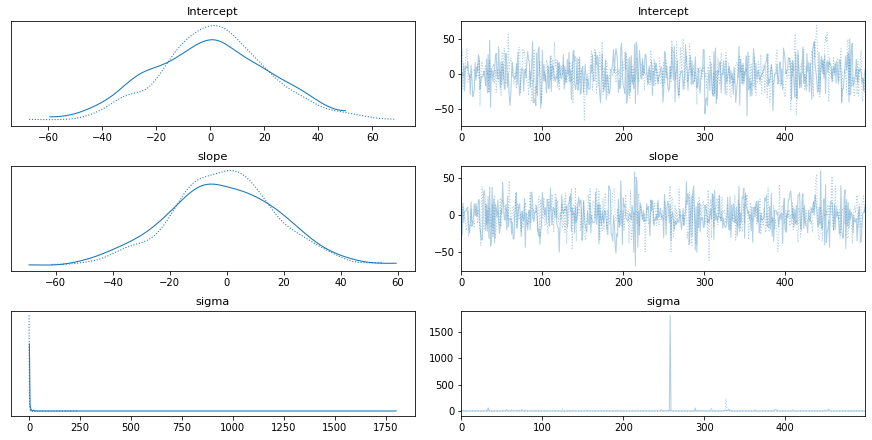

In [ ]:
with wind_m:
    trace_wind = pm.sample(500,cores=2)
pm.traceplot(trace)

In [ ]:
intercept = trace_wind['Intercept']
slope = trace_wind['slope']
wind_posterior = ((intercept + np.dot(slope, merkel_1_p['wind_speed'][:, None]))) * merkel_1_p['power'].max()

ValueError: ignored

In [ ]:
trace_wind['slope'].shape

(1000,)

In [ ]:
wind_data = merkel_1_p['wind_speed'].values

In [ ]:
wind_data.shape

(678,)

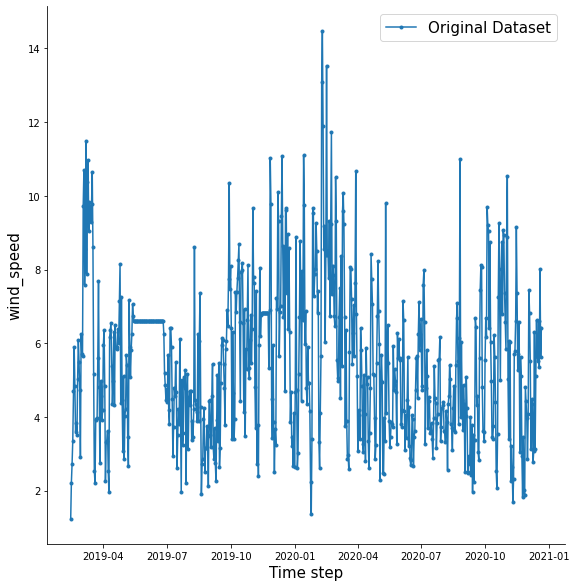

In [ ]:
seris_plot(merkel_1_p,'wind_speed','datetime')

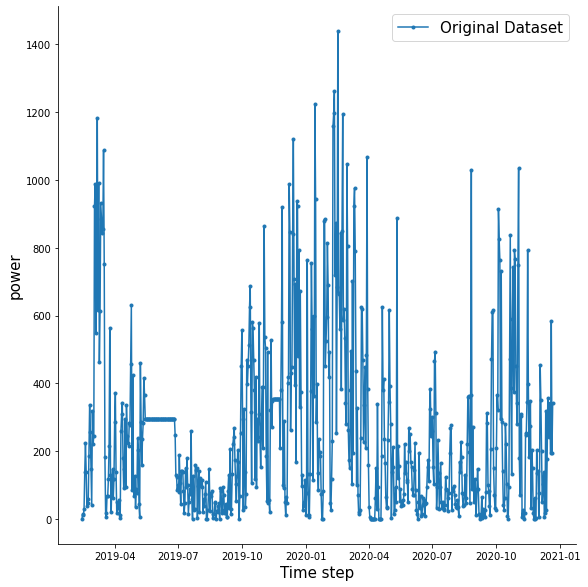

In [ ]:
seris_plot(merkel_1_p,'power','datetime')